## Notes

- negative correlation with r_perc seems pretty robust. 
- look at distribution of first cases and exposure days by vote share. likely that red counties benefitted from slow spread. national panic had already reached a high by the time it hit them so they were quick to react.

- What should I do with the extreme outliers?


- What should I make of changes from sampling at >0 deaths
    - try logging and square roots

- Should I be concerned with the logit predicting all pos? better fit from model without vote share?
    - don't really worry about it

In [27]:
library(car)
library(dplyr)
library(ggplot2)
library(ROCR)
library(pROC)
library(stargazer)


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [3]:
df <- read.csv('covid_county.csv')

Some cleaning...

In [4]:
# convert to date format
df$stay_home_date <- as.Date(df$stay_home_date)
df$first_case <- as.Date(df$first_case)

# create exposure days variable, the number of days after the first case in which no lockdown was in place
# if there is no order, todays date minus first case. If there is, order date minus first case
df$exp_days <- ifelse(is.na(df$stay_home_date), as.Date('2020-04-26') - df$first_case, df$stay_home_date - df$first_case)
df$exp_days[df$exp_days < 0] <- 0

df$adjexp_days <- ifelse(is.na(df$stay_home_date), as.Date('2020-04-26') - as.Date('2020-03-16'), df$stay_home_date - as.Date('2020-03-16'))

# create deaths per capita
df$dpc <- df$deaths/df$pop2018

# create cases per capita
df$cpc <- df$cases/df$pop2018

# % elderly
df$eld_perc <- df$over652018/df$pop2018

# republican majority binary
df$rmaj <- ifelse(df$r_percent > df$d_percent, 1, 0)
df$dmaj <- ifelse(df$d_percent > df$r_percent, 1, 0)

# days since first case
df$since_first <- as.Date('2020-04-26')-df$first_case

# distance between when a county had its first stay at home order and when federal stay at home guidelines were issued
df$dist_from_stayhome <- df$first_case - as.Date('2020-03-16')

# dummy for whether a stay at home order was issued
df$stayhome_issued <- ifelse(!is.na(df$stay_home_date), 1, 0)

In [238]:
head(df)

,state,county,pop2018,over652018,dens2019,cases,first_case,deaths,first_death,stay_home_date,⋯,obesity,exp_days,adjexp_days,dpc,cpc,eld_perc,rmaj,dmaj,dist_from_stayhome,stayhome_issued
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<date>,<int>,<fct>,<date>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>,<dbl>
1,Alabama,Autauga County,55601,8653,93.54,609,2020-03-24,23,2020-04-08,2020-04-04,⋯,0.305,11,19,4.136616e-04,0.010953040,0.1556267,1,0,8 days,1
2,Alabama,Baldwin County,218022,44571,137.14,2283,2020-03-14,21,2020-04-18,2020-04-04,⋯,0.266,21,19,9.632055e-05,0.010471420,0.2044335,1,0,-2 days,1
3,Alabama,Barbour County,24881,4832,28.11,357,2020-04-03,0,,2020-04-04,⋯,0.373,1,19,0.000000e+00,0.014348298,0.1942044,1,0,18 days,1
4,Alabama,Bibb County,22400,3690,35.99,492,2020-03-31,0,,2020-04-04,⋯,0.343,4,19,0.000000e+00,0.021964286,0.1647321,1,0,15 days,1
5,Alabama,Blount County,57840,10548,89.70,478,2020-03-25,0,,2020-04-04,⋯,0.304,10,19,0.000000e+00,0.008264177,0.1823651,1,0,9 days,1
6,Alabama,Bullock County,10138,1661,16.28,186,2020-03-26,0,,2020-04-04,⋯,0.421,9,19,0.000000e+00,0.018346814,0.1638390,0,1,10 days,1


# H3: Deaths

In [255]:
# model total deaths
d1 <- lm(deaths ~ log(pop2018) + eld_perc + dens2019 + obesity + since_first + exp_days + r_percent, data = df)
summary(d1)

vif(d1)


Call:
lm(formula = deaths ~ log(pop2018) + eld_perc + dens2019 + obesity + 
    exp_days, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3651.5  -202.9   -49.2    84.9 20666.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.887e+03  2.376e+02  -7.943 2.86e-15 ***
log(pop2018)  1.854e+02  1.299e+01  14.271  < 2e-16 ***
eld_perc      6.361e+02  3.728e+02   1.706  0.08805 .  
dens2019      3.843e-02  8.245e-03   4.660 3.31e-06 ***
obesity      -3.134e+02  3.669e+02  -0.854  0.39308    
exp_days      3.842e+00  1.342e+00   2.863  0.00422 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 776.9 on 2751 degrees of freedom
  (385 observations deleted due to missingness)
Multiple R-squared:  0.1231,	Adjusted R-squared:  0.1215 
F-statistic: 77.26 on 5 and 2751 DF,  p-value: < 2.2e-16


log(pop2018)     eld_perc     dens2019      obesity     exp_days 
    1.453491     1.262718     1.084700     1.144142     1.084368

In [331]:
# log cases as a control for log deaths
# log elderly and other raw numbers rather than density etc.
# sqrt/4th root transformation. cube root for neg numbers
d1 <- lm(log(deaths + .000001) ~ log(pop2018) + eld_perc + dens2019 + obesity + since_first + exp_days + r_percent, data = df[df$deaths >= 0,])
summary(d1)

vif(d1)


Call:
lm(formula = log(deaths + 1) ~ log(pop2018) + eld_perc + dens2019 + 
    obesity + since_first + exp_days + r_percent, data = df[df$deaths >= 
    0, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-7.4275 -1.2615 -0.1064  1.2907  4.8337 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.015e+01  5.758e-01 -17.619  < 2e-16 ***
log(pop2018)  8.411e-01  3.710e-02  22.669  < 2e-16 ***
eld_perc      9.206e-01  8.261e-01   1.114 0.265209    
dens2019     -5.438e-05  1.825e-05  -2.979 0.002916 ** 
obesity       7.412e+00  8.137e-01   9.109  < 2e-16 ***
since_first   4.012e-02  4.845e-03   8.280  < 2e-16 ***
exp_days     -4.238e-03  3.325e-03  -1.274 0.202670    
r_percent    -9.660e-03  2.510e-03  -3.848 0.000122 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.707 on 2740 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.4195,	Adjusted R-squared:  0.4

log(pop2018)     eld_perc     dens2019      obesity  since_first     exp_days 
    2.450358     1.272851     1.101434     1.164908     2.587530     1.377910 
   r_percent 
    1.373990

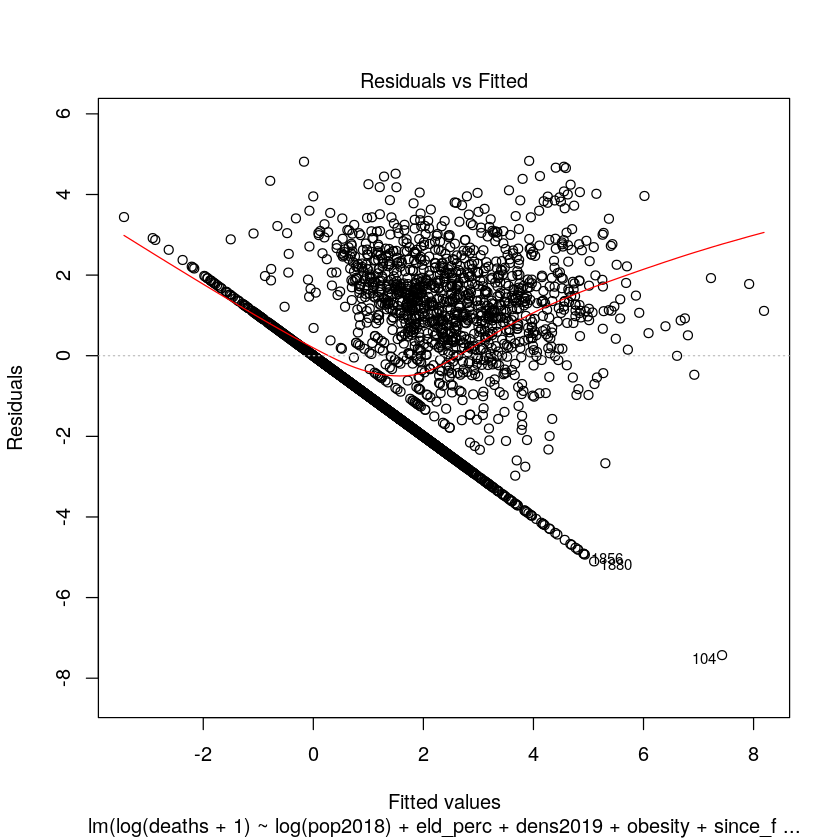

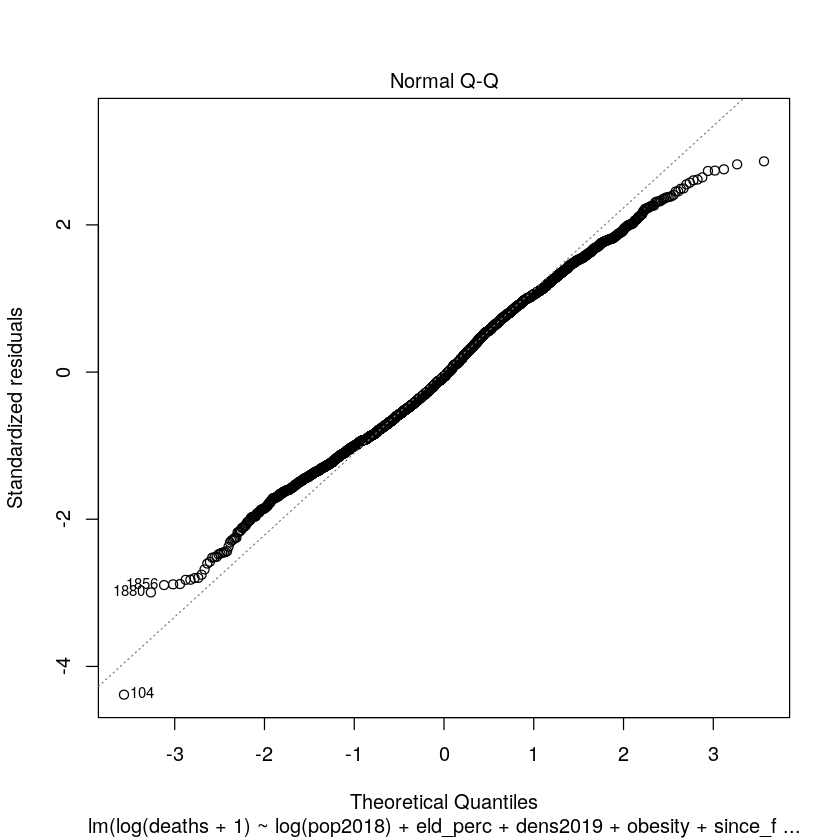

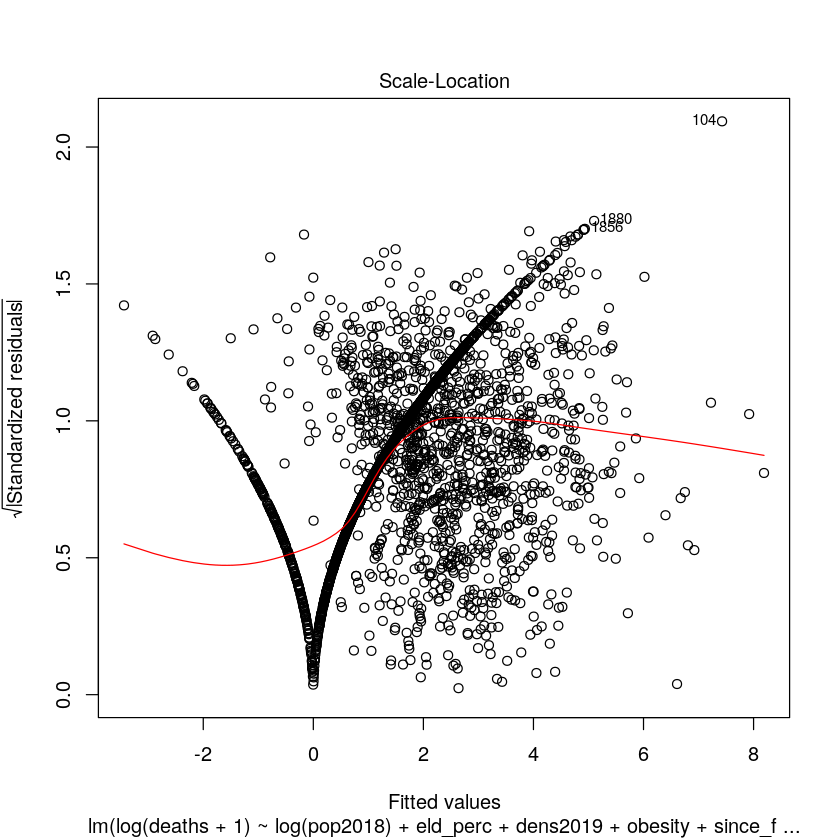

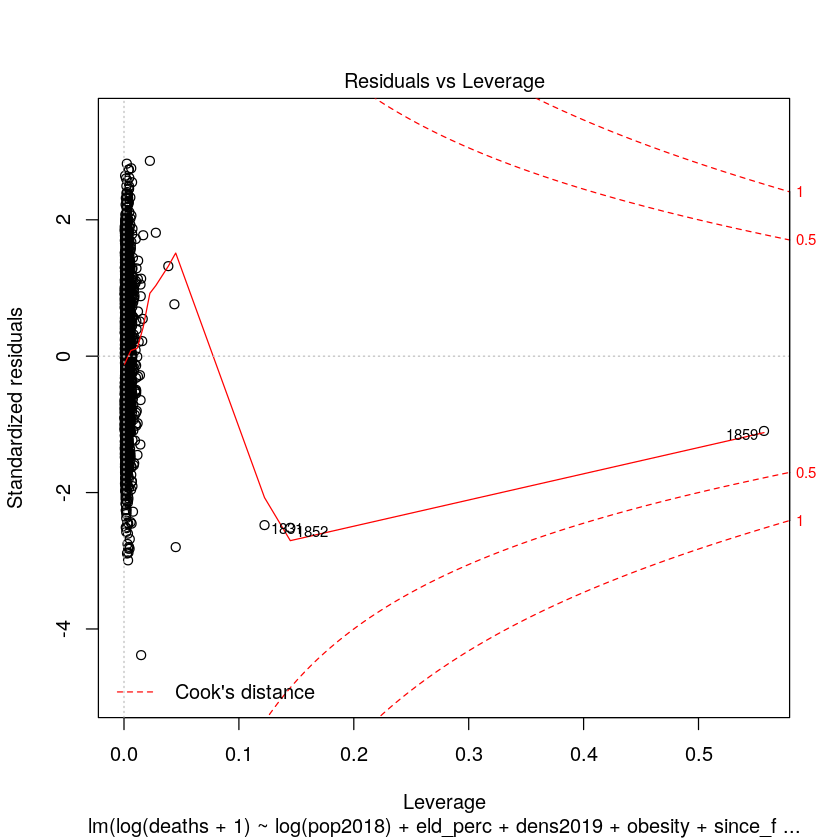

In [332]:
plot(d1)

In [87]:
# deaths per capita
d2 <- lm(dpc ~ eld_perc + dens2019 + obesity + exp_days, data = df)
summary(d2)

vif(d2)


Call:
lm(formula = dpc ~ eld_perc + dens2019 + obesity + exp_days, 
    data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.004596 -0.000654 -0.000490 -0.000110  0.033354 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.742e-05  3.311e-04  -0.083 0.934007    
eld_perc    -2.271e-03  8.394e-04  -2.705 0.006864 ** 
dens2019     6.057e-08  1.992e-08   3.041 0.002377 ** 
obesity      3.332e-03  8.627e-04   3.862 0.000115 ***
exp_days     6.749e-06  3.258e-06   2.072 0.038393 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001914 on 2752 degrees of freedom
  (385 observations deleted due to missingness)
Multiple R-squared:  0.01376,	Adjusted R-squared:  0.01232 
F-statistic: 9.597 on 4 and 2752 DF,  p-value: 1.05e-07


eld_perc dens2019  obesity exp_days 
1.054879 1.042867 1.042438 1.053459

In [322]:
# Instrumental variable? changes on r_percent but no change on deaths
d3 <- lm(log(dpc + 0.000000001) ~ eld_perc + dens2019 + obesity + since_first + exp_days + r_percent, data = df[df$deaths >0,])
summary(d3)

vif(d3)


Call:
lm(formula = log(dpc + 1e-09) ~ eld_perc + dens2019 + obesity + 
    since_first + exp_days + r_percent, data = df[df$deaths > 
    0, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8049 -0.7721  0.0592  0.8900  3.8758 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.091e+01  5.161e-01 -21.142  < 2e-16 ***
eld_perc     4.747e+00  9.412e-01   5.044 5.24e-07 ***
dens2019     1.430e-04  4.228e-05   3.383  0.00074 ***
obesity      6.111e+00  9.758e-01   6.262 5.23e-10 ***
since_first  2.731e-02  6.188e-03   4.414 1.11e-05 ***
exp_days    -1.143e-02  4.087e-03  -2.797  0.00523 ** 
r_percent   -2.616e-03  2.854e-03  -0.917  0.35950    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.337 on 1237 degrees of freedom
  (52 observations deleted due to missingness)
Multiple R-squared:  0.05837,	Adjusted R-squared:  0.0538 
F-statistic: 12.78 on 6 and 1237 DF,  p-value: 4.832e-14


eld_perc    dens2019     obesity since_first    exp_days   r_percent 
   1.104936    1.340642    1.246422    2.226419    1.555169    1.367734

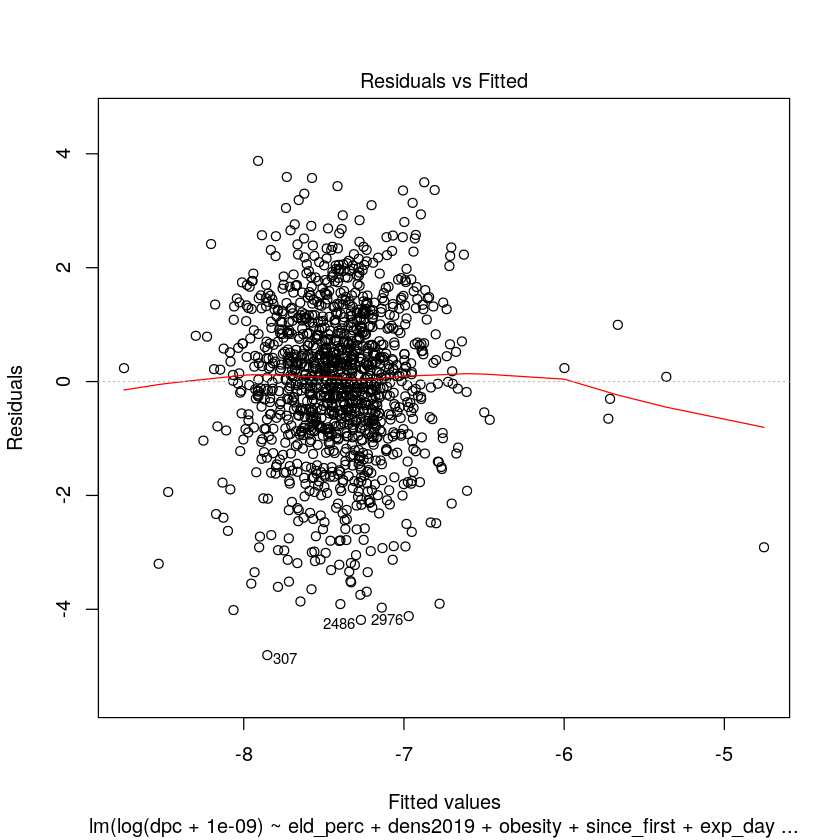

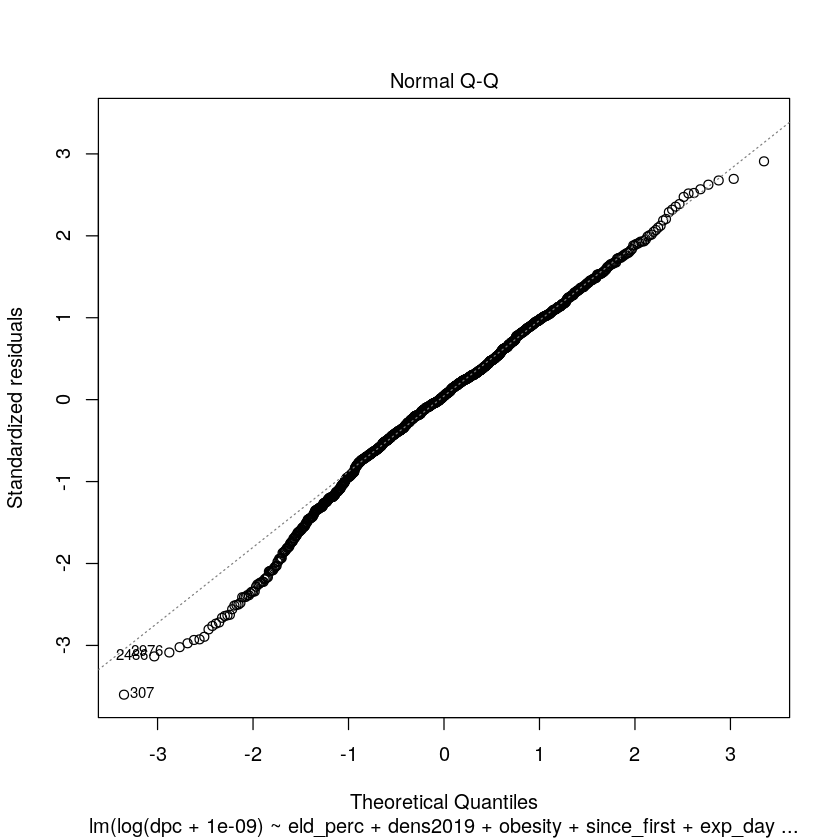

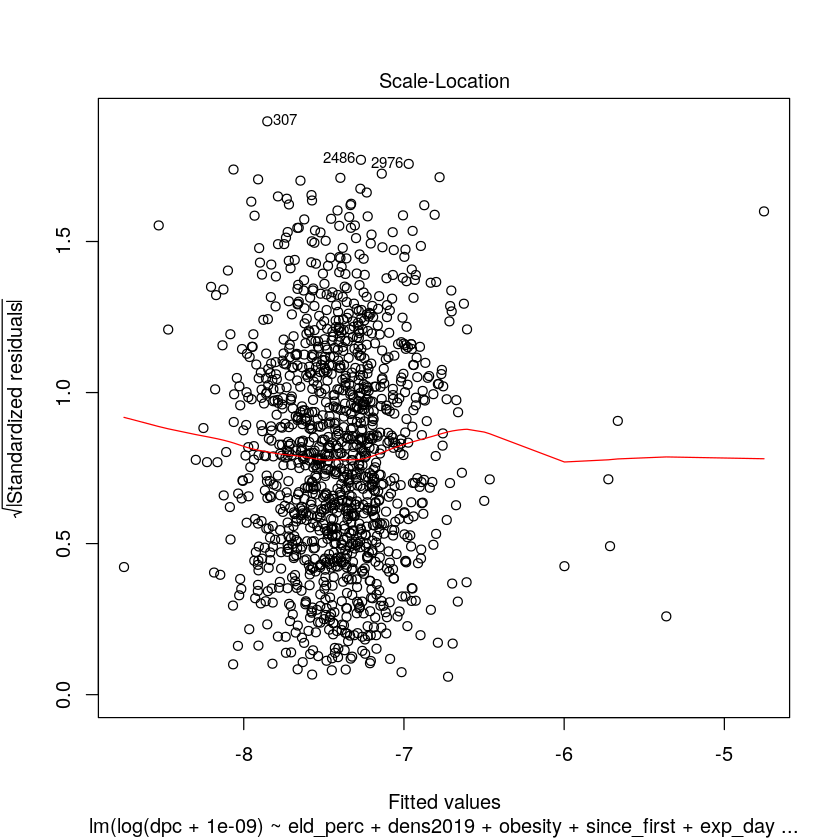

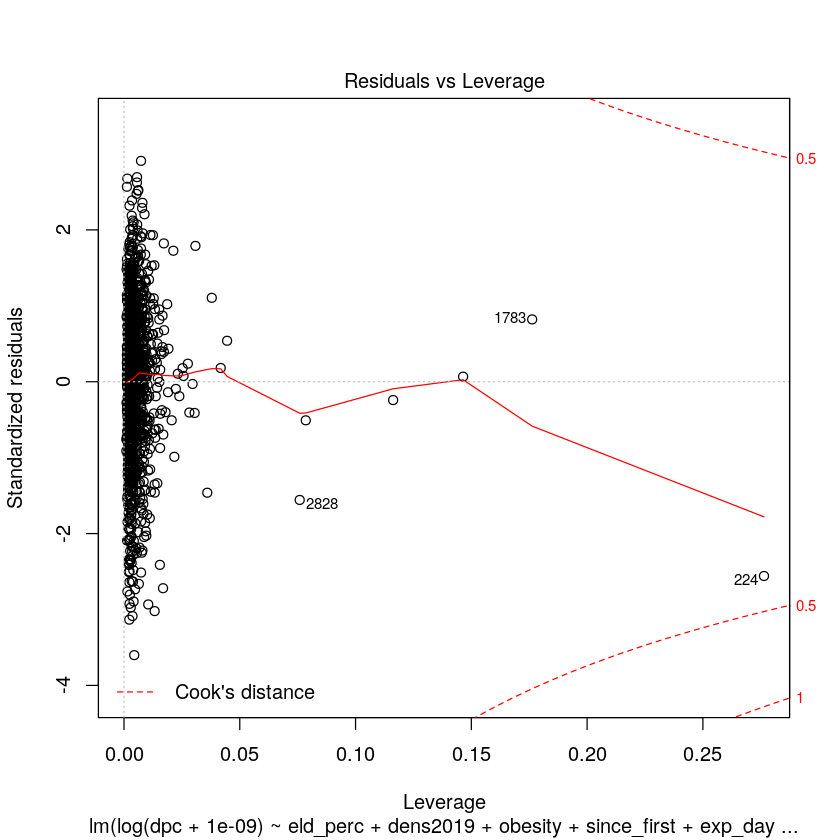

In [323]:
plot(d3)

In [303]:
df$since_first <- as.numeric(df$since_first)

In [304]:
# correlations. Very strong negative correlation with days since first case and r_percent. strong positive with exp days and r_percent
cor(df[,c(5, 6, 11, 14, 15, 16, 17, 18, 19, 21, 26)], use = 'complete.obs')

,dens2019,cases,r_percent,l_percent,poverty,obesity,exp_days,adjexp_days,dpc,eld_perc,since_first
dens2019,1.00000000,0.64026876,-0.23868926,-0.05080491,-0.01805429,-0.15980186,0.08955213,-0.07655583,0.05580322,-0.10469101,0.20347165
cases,0.64026876,1.00000000,-0.24516362,-0.07043211,-0.04911864,-0.17235538,0.11203490,-0.09566299,0.13997496,-0.10613601,0.25212579
r_percent,-0.23868926,-0.24516362,1.00000000,-0.13387746,-0.08632279,0.23595438,-0.17628593,0.17199705,-0.16286228,0.21538136,-0.44656780
l_percent,-0.05080491,-0.07043211,-0.13387746,1.00000000,-0.39922301,-0.38969928,0.11645603,0.03698412,-0.14116733,-0.07148963,0.08100309
poverty,-0.01805429,-0.04911864,-0.08632279,-0.39922301,1.00000000,0.46757883,-0.10607545,0.01907798,0.08166962,-0.06874642,-0.15284896
obesity,-0.15980186,-0.17235538,0.23595438,-0.38969928,0.46757883,1.00000000,-0.09663955,0.14045461,0.06440400,-0.05738279,-0.26068729
exp_days,0.08955213,0.11203490,-0.17628593,0.11645603,-0.10607545,-0.09663955,1.00000000,0.71175940,0.04780118,-0.19429637,0.49906975
adjexp_days,-0.07655583,-0.09566299,0.17199705,0.03698412,0.01907798,0.14045461,0.71175940,1.00000000,-0.07849320,-0.00650162,-0.16403491
dpc,0.05580322,0.13997496,-0.16286228,-0.14116733,0.08166962,0.06440400,0.04780118,-0.07849320,1.00000000,-0.07245509,0.19586508
eld_perc,-0.10469101,-0.10613601,0.21538136,-0.07148963,-0.06874642,-0.05738279,-0.19429637,-0.00650162,-0.07245509,1.00000000,-0.30011901


# H2: Exposure Days

do exposure days matter? Maybe public awareness matters more and people maintain social distancing regardless of stay at home order if public awareness is high enough. 

In [148]:
colnames(df)

[1] "state"              "county"             "pop2018"           
 [4] "over652018"         "dens2019"           "cases"             
 [7] "first_case"         "deaths"             "first_death"       
[10] "stay_home_date"     "r_percent"          "d_percent"         
[13] "g_percent"          "l_percent"          "poverty"           
[16] "obesity"            "exp_days"           "adjexp_days"       
[19] "dpc"                "cpc"                "eld_perc"          
[22] "rmaj"               "dmaj"               "since_first"       
[25] "dist_from_stayhome" "stayhome_issued"

In [161]:
# neg dist from stayhome coeff means the earlier your county had a case, the more exposure days you are likely to have
exp1 <- lm(exp_days ~  r_percent + eld_perc  + dens2019 + since_first, data = df)
summary(exp1)

vif(exp1)


Call:
lm(formula = exp_days ~ r_percent + eld_perc + dens2019 + since_first, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.150  -6.843  -3.013   2.438  38.802 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.656e+00  1.593e+00  -4.807 1.62e-06 ***
r_percent    4.745e-02  1.419e-02   3.345 0.000835 ***
eld_perc    -1.416e+01  4.490e+00  -3.154 0.001626 ** 
dens2019    -3.270e-05  1.049e-04  -0.312 0.755352    
since_first  5.441e-01  2.025e-02  26.868  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.934 on 2743 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.2545,	Adjusted R-squared:  0.2534 
F-statistic: 234.1 on 4 and 2743 DF,  p-value: < 2.2e-16


r_percent    eld_perc    dens2019 since_first 
   1.295930    1.110146    1.074811    1.334775

In [163]:
# neg dist from stayhome coeff means the earlier your county had a case, the more exposure days you are likely to have
exp1A <- lm(exp_days ~  r_percent + eld_perc  + dens2019 + since_first, data = df[df$stayhome_issued == 1,])
summary(exp1A)

vif(exp1A)


Call:
lm(formula = exp_days ~ r_percent + eld_perc + dens2019 + since_first, 
    data = df[df$stayhome_issued == 1, ])

Residuals:
   Min     1Q Median     3Q    Max 
-9.635 -4.031 -0.380  3.230 32.169 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.044e+01  9.093e-01 -11.478   <2e-16 ***
r_percent   -1.084e-02  7.916e-03  -1.369    0.171    
eld_perc    -3.858e+00  2.514e+00  -1.535    0.125    
dens2019     5.018e-05  5.529e-05   0.908    0.364    
since_first  5.709e-01  1.177e-02  48.510   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.214 on 2328 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.588,	Adjusted R-squared:  0.5873 
F-statistic: 830.6 on 4 and 2328 DF,  p-value: < 2.2e-16


r_percent    eld_perc    dens2019 since_first 
   1.301116    1.099444    1.079031    1.342978

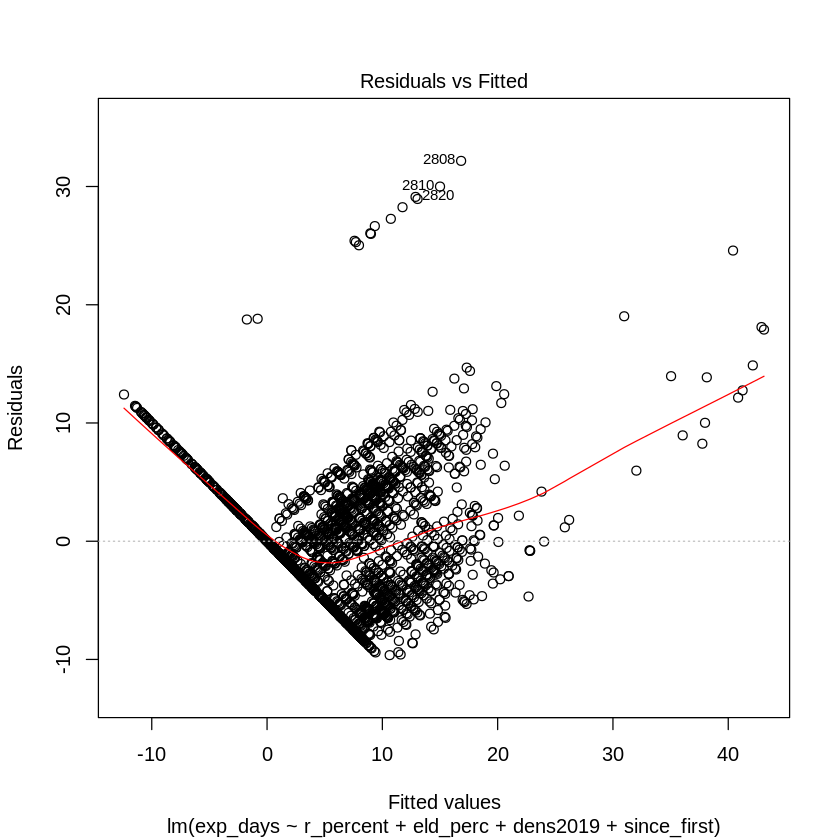

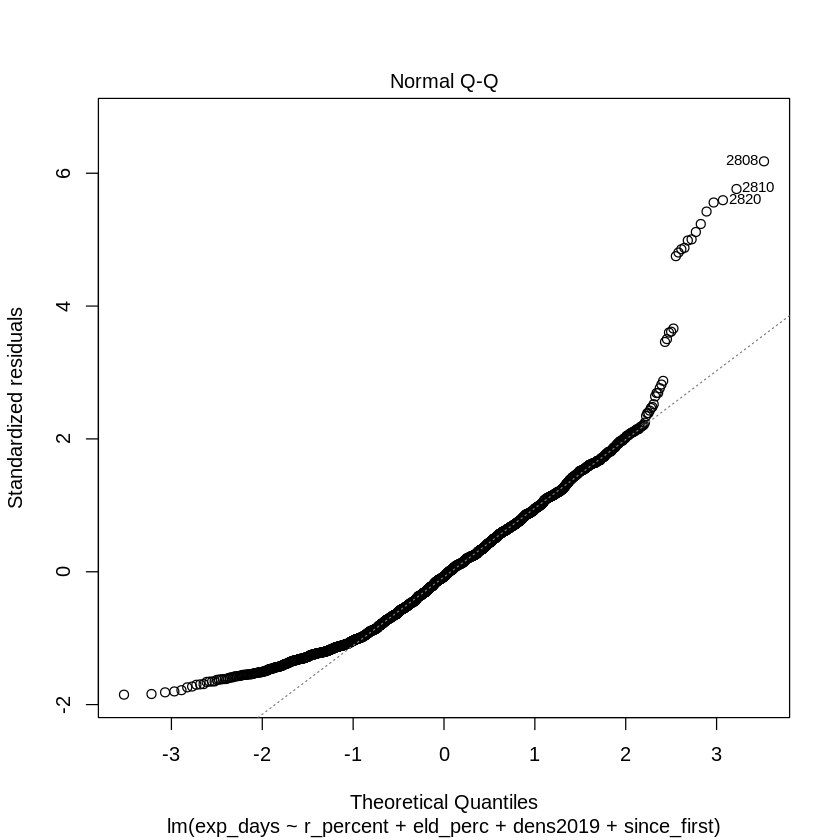

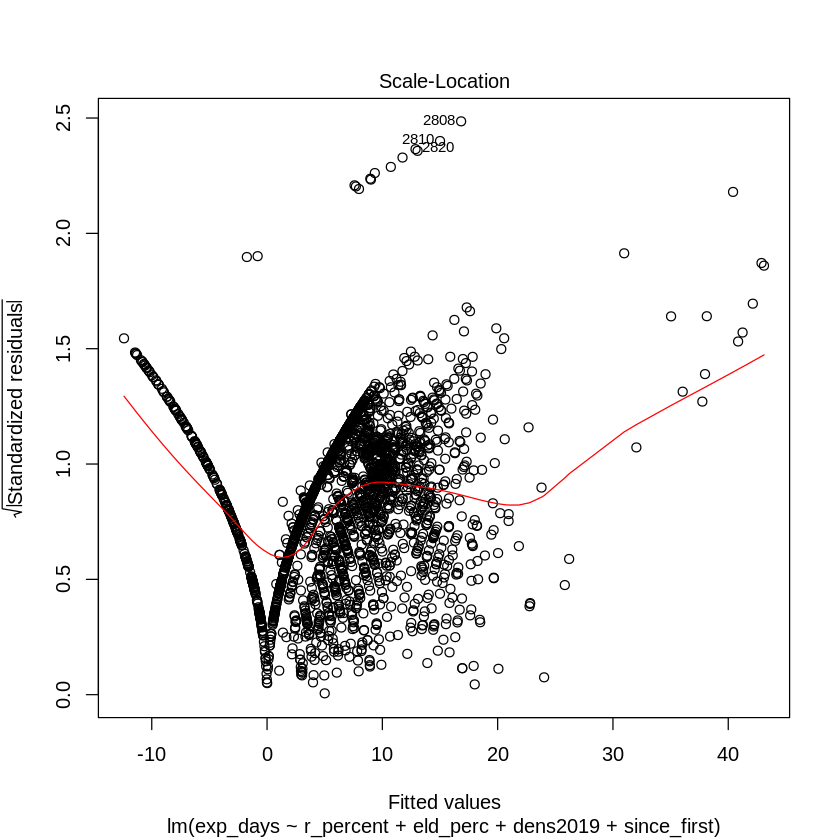

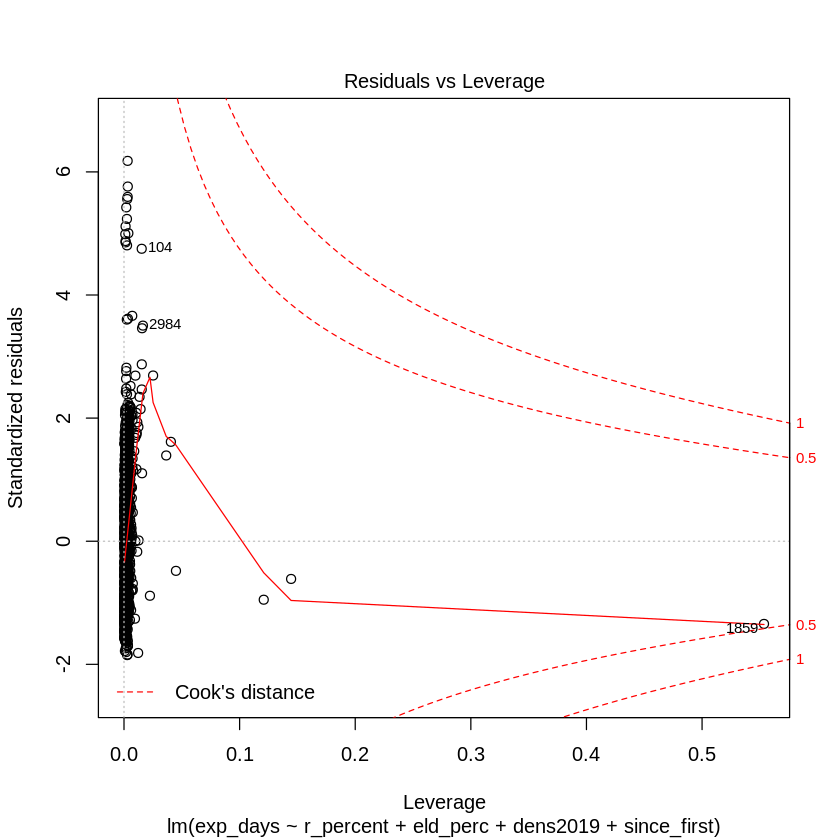

In [171]:
plot(exp1A)

In [166]:
exp2 <- lm(adjexp_days ~ eld_perc + dens2019 + dist_from_stayhome + r_percent, data = df)
summary(exp2)

vif(exp2)


Call:
lm(formula = adjexp_days ~ eld_perc + dens2019 + dist_from_stayhome + 
    r_percent, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-16.310  -8.279  -2.618   2.516  29.904 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.318e+01  1.276e+00  10.328  < 2e-16 ***
eld_perc           -1.913e+01  5.093e+00  -3.756 0.000176 ***
dens2019           -1.788e-04  1.190e-04  -1.502 0.133283    
dist_from_stayhome  1.324e-01  2.297e-02   5.763 9.19e-09 ***
r_percent           9.506e-02  1.609e-02   5.906 3.93e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.27 on 2743 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.04467,	Adjusted R-squared:  0.04328 
F-statistic: 32.06 on 4 and 2743 DF,  p-value: < 2.2e-16


eld_perc           dens2019 dist_from_stayhome          r_percent 
          1.110146           1.074811           1.334775           1.295930

In [169]:
# dist_from_stayhome is how many days since federal stay at home orders was the first case
# interact r_percent and dist_from_stayhome
exp2A <- lm(adjexp_days ~ eld_perc + dens2019 + dist_from_stayhome + r_percent, data = df[df$stayhome_issued == 1,])
summary(exp2A)

vif(exp2A)


Call:
lm(formula = adjexp_days ~ eld_perc + dens2019 + dist_from_stayhome + 
    r_percent, data = df[df$stayhome_issued == 1, ])

Residuals:
   Min     1Q Median     3Q    Max 
-9.804 -4.680 -0.497  4.436 29.553 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.116e+01  6.835e-01  16.334  < 2e-16 ***
eld_perc           -8.341e+00  2.713e+00  -3.074  0.00214 ** 
dens2019           -1.367e-04  5.968e-05  -2.291  0.02206 *  
dist_from_stayhome  1.524e-02  1.270e-02   1.200  0.23023    
r_percent           4.331e-02  8.544e-03   5.069 4.31e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.628 on 2328 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.02318,	Adjusted R-squared:  0.02151 
F-statistic: 13.81 on 4 and 2328 DF,  p-value: 3.878e-11


eld_perc           dens2019 dist_from_stayhome          r_percent 
          1.099444           1.079031           1.342978           1.301116

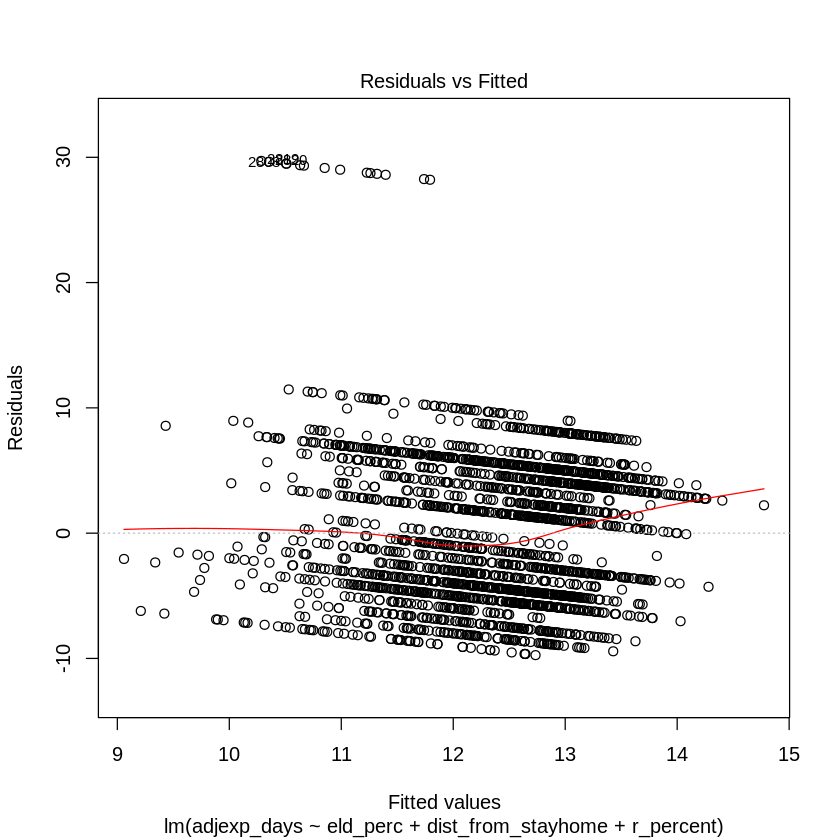

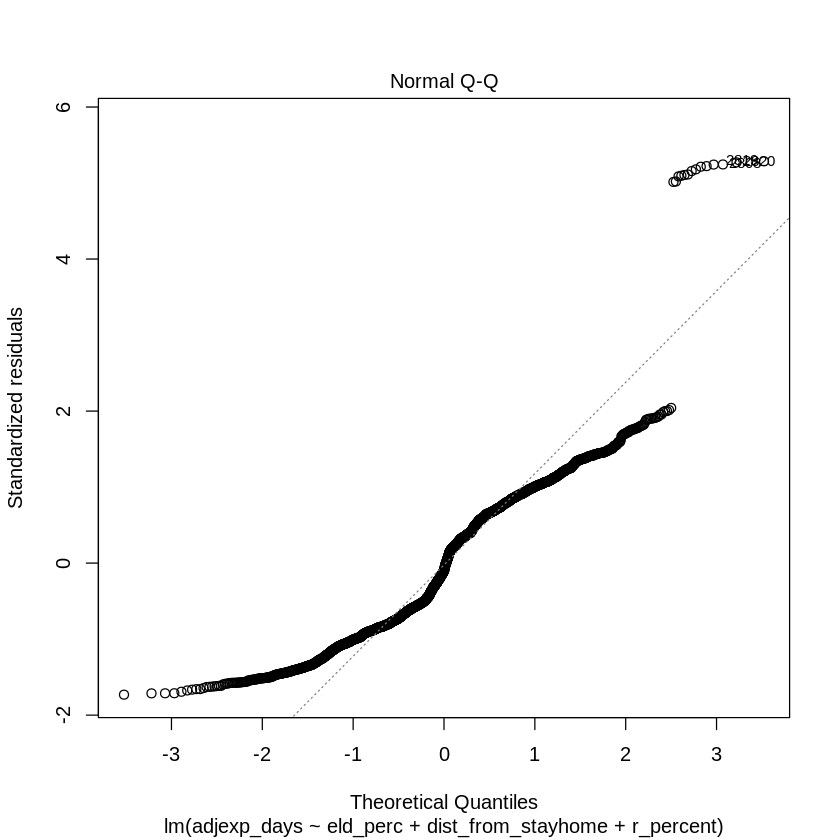

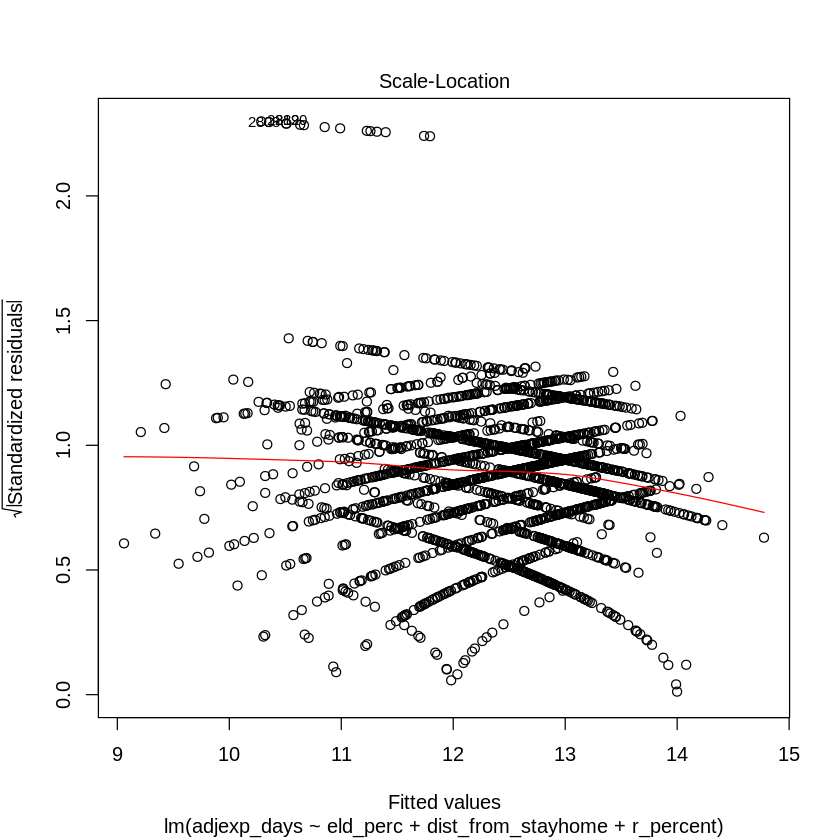

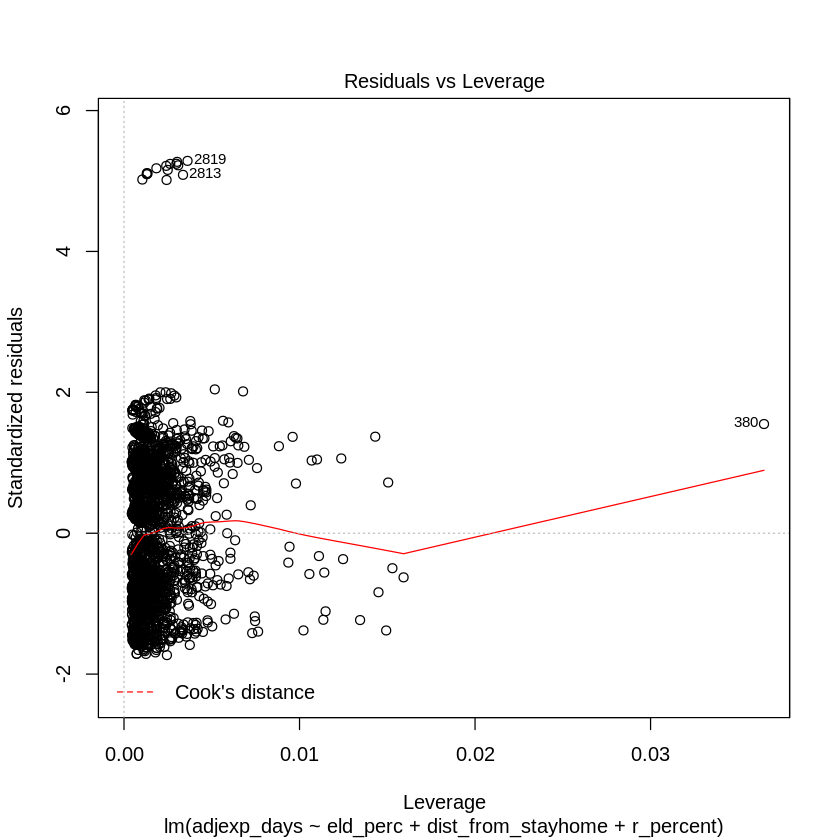

In [159]:
plot(exp2)

# H1: Stay home order issued

In [16]:
colnames(df)

[1] "state"              "county"             "pop2018"           
 [4] "over652018"         "dens2019"           "cases"             
 [7] "first_case"         "deaths"             "first_death"       
[10] "stay_home_date"     "r_percent"          "d_percent"         
[13] "g_percent"          "l_percent"          "poverty"           
[16] "obesity"            "exp_days"           "adjexp_days"       
[19] "dpc"                "cpc"                "eld_perc"          
[22] "rmaj"               "dmaj"               "since_first"       
[25] "dist_from_stayhome" "stayhome_issued"

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = stayhome_issued ~ r_percent + dpc + eld_perc + 
    dens2019, family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3919   0.2261   0.5723   0.6862   0.9649  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.646e+00  3.547e-01   4.641 3.47e-06 ***
r_percent   -1.571e-02  3.923e-03  -4.005 6.20e-05 ***
dpc          2.204e+02  6.839e+01   3.223  0.00127 ** 
eld_perc     2.784e+00  1.171e+00   2.376  0.01749 *  
dens2019     4.795e-03  7.511e-04   6.385 1.72e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2771.0  on 3061  degrees of freedom
Residual deviance: 2590.5  on 3057  degrees of freedom
  (80 observations deleted due to missingness)
AIC: 2600.5

Number of Fisher Scoring iterations: 8


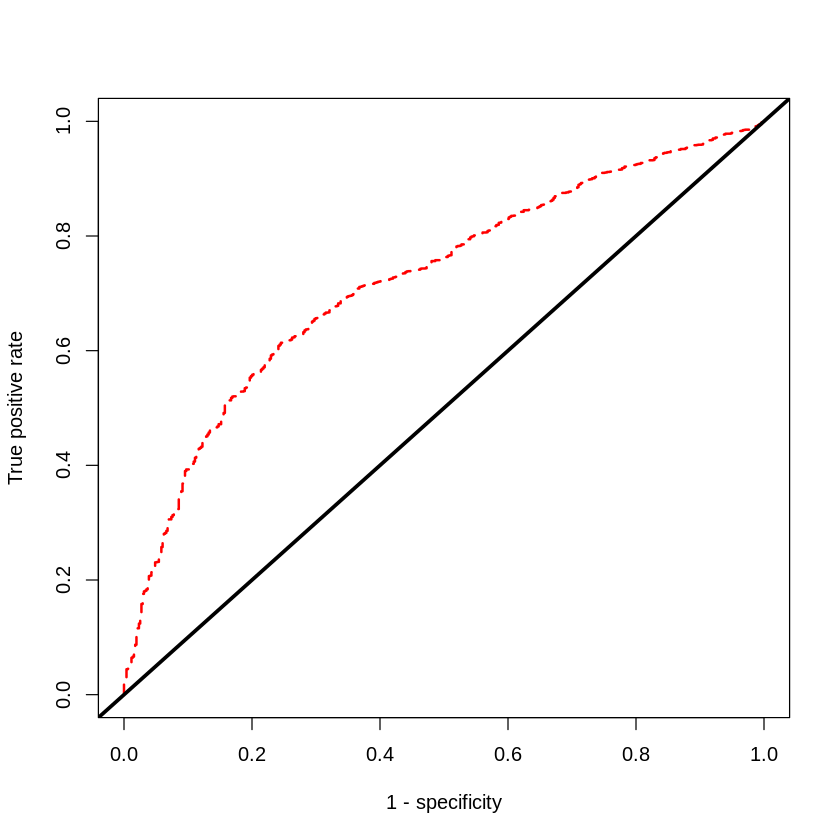

In [93]:
# run a model with and without obesity? It's clear obesity may make a population more vulnerable
# but less clear that this would be considered in decision making
home1 <- glm(stayhome_issued ~ r_percent + dpc + eld_perc + dens2019, data = df, family=binomial(link="logit"))
summary(home1)


# subset to complete cases
logdf <- df[,c('dpc', 'eld_perc', 'dens2019', 'r_percent', 'stayhome_issued')]
logdf <- logdf[complete.cases(logdf),]

# ROC curve
home1.hats <- predict(home1, type = "response")
# get predictions 
preds1 <- prediction(home1.hats, logdf$stayhome_issued)

#plot
plot(performance(preds1, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = stayhome_issued ~ r_percent + dpc + cpc + eld_perc + 
    dens2019, family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3969   0.2265   0.5717   0.6850   0.9585  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.716e+00  3.650e-01   4.700 2.60e-06 ***
r_percent   -1.619e-02  3.971e-03  -4.078 4.53e-05 ***
dpc          2.444e+02  7.473e+01   3.271  0.00107 ** 
cpc         -1.887e+00  2.270e+00  -0.831  0.40584    
eld_perc     2.687e+00  1.177e+00   2.282  0.02247 *  
dens2019     4.800e-03  7.501e-04   6.399 1.56e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2771.0  on 3061  degrees of freedom
Residual deviance: 2589.8  on 3056  degrees of freedom
  (80 observations deleted due to missingness)
AIC: 2601.8

Number of Fisher Scoring iterations: 8


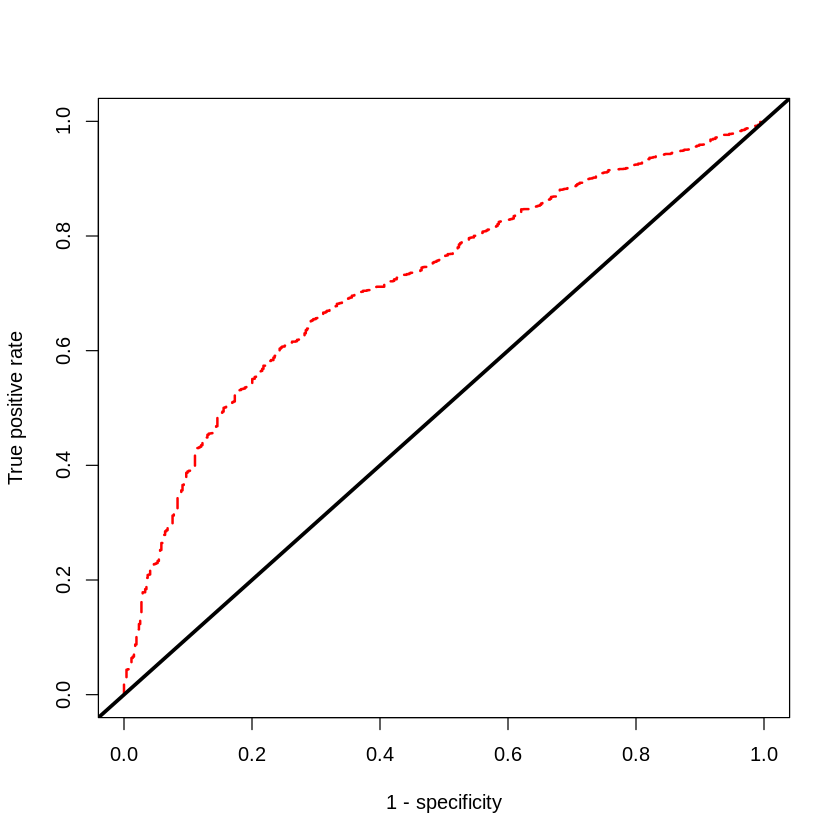

In [67]:
home1c <- glm(stayhome_issued ~ r_percent + dpc + cpc + eld_perc + dens2019, data = df, family=binomial(link="logit"))
summary(home1c)


# subset to complete cases
logdf <- df[,c('dpc', 'cpc', 'eld_perc', 'dens2019', 'r_percent', 'stayhome_issued')]
logdf <- logdf[complete.cases(logdf),]

# ROC curve
home1c.hats <- predict(home1c, type = "response")
# get predictions 
preds <- prediction(home1c.hats, logdf$stayhome_issued)

#plot
plot(performance(preds, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

In [116]:
# get the area under the curve
homeroc <- roc(logdf$stayhome_issued, home1.hats, ci=TRUE)
m1auc <- auc(homeroc)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [143]:
# predicting everything to be
table(home1$fitted.values>0.5,logdf$stayhome_issued == 1)

      
       FALSE TRUE
  TRUE   514 2548


Call:
glm(formula = stayhome_issued ~ r_percent + log(deaths + 1e-06) + 
    log(over652018) + log(pop2018), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7114   0.2828   0.4793   0.6488   2.1473  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.823256   0.672485  -1.224 0.220877    
r_percent           -0.008436   0.003940  -2.141 0.032261 *  
log(deaths + 1e-06)  0.026398   0.007734   3.413 0.000642 ***
log(over652018)      1.276178   0.238191   5.358 8.42e-08 ***
log(pop2018)        -0.739853   0.224541  -3.295 0.000984 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2773.2  on 3067  degrees of freedom
Residual deviance: 2505.8  on 3063  degrees of freedom
  (74 observations deleted due to missingness)
AIC: 2515.8

Number of Fisher Scoring iterations: 5


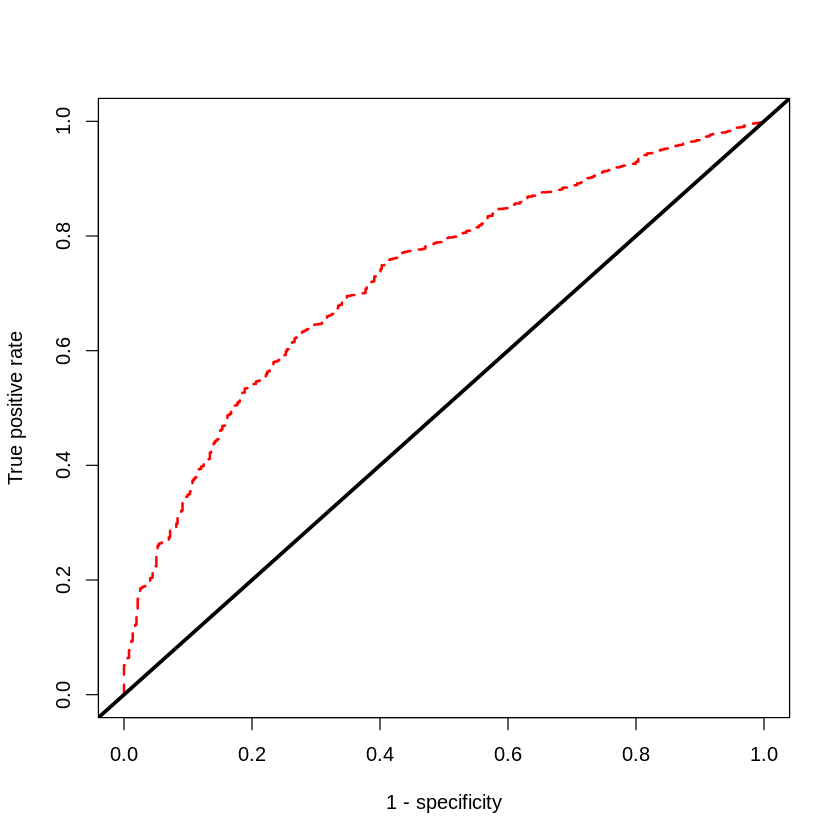

In [83]:
# run a model with and without obesity? It's clear obesity may make a population more vulnerable
# but less clear that this would be considered in decision making
home2 <- glm(stayhome_issued ~ r_percent + log(deaths + .000001) + log(over652018) + log(pop2018),  data = df, family=binomial(link="logit"))
summary(home2)


# subset to complete cases
logdf2 <- df[,c('deaths', 'over652018', 'pop2018', 'r_percent', 'stayhome_issued')]
logdf2 <- logdf2[complete.cases(logdf2),]

# ROC curve
home2.hats <- predict(home2, type = "response")
# get predictions 
preds2 <- prediction(home2.hats, logdf2$stayhome_issued)

#plot
plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

In [144]:
# Confusion Matrix
table(home2$fitted.values>0.5,logdf2$stayhome_issued == 1)

       
        FALSE TRUE
  FALSE    16   19
  TRUE    498 2535

In [147]:
# VIF
vif(home2)
vif(home1)

r_percent log(deaths + 1e-06)     log(over652018)        log(pop2018) 
           1.177275            1.266943           30.109616           31.046428

r_percent       dpc  eld_perc  dens2019 
 1.068792  1.029573  1.099449  1.136784


Call:
glm(formula = stayhome_issued ~ r_percent + log(deaths + 1e-06) + 
    log(over652018) + log(pop2018), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7114   0.2828   0.4793   0.6488   2.1473  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.823256   0.672485  -1.224 0.220877    
r_percent           -0.008436   0.003940  -2.141 0.032261 *  
log(deaths + 1e-06)  0.026398   0.007734   3.413 0.000642 ***
log(over652018)      1.276178   0.238191   5.358 8.42e-08 ***
log(pop2018)        -0.739853   0.224541  -3.295 0.000984 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2773.2  on 3067  degrees of freedom
Residual deviance: 2505.8  on 3063  degrees of freedom
  (74 observations deleted due to missingness)
AIC: 2515.8

Number of Fisher Scoring iterations: 5


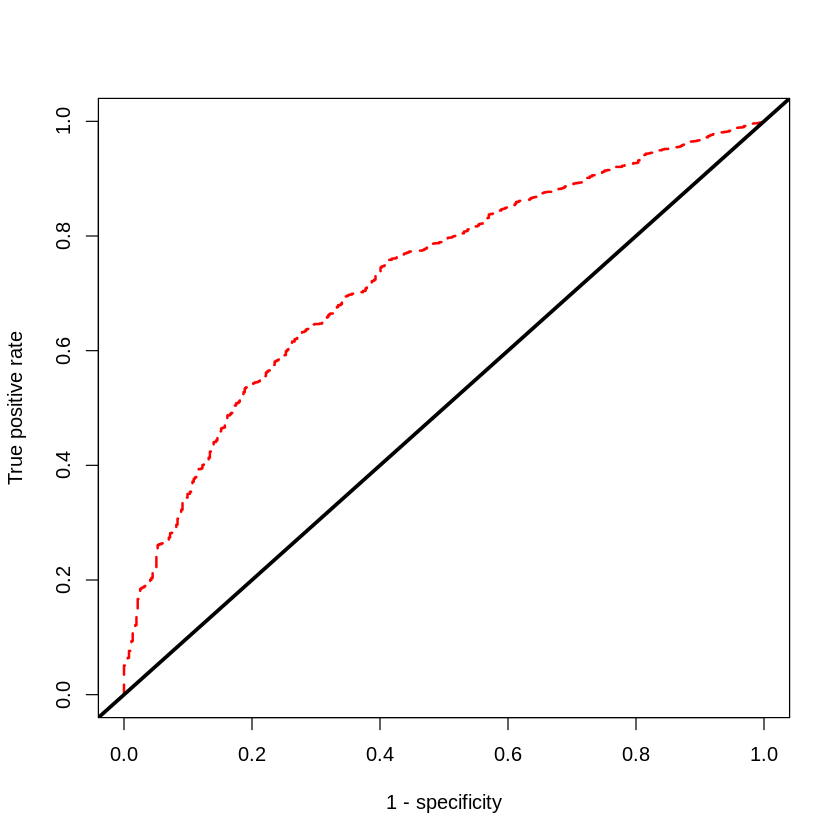

In [71]:
home2c <- glm(stayhome_issued ~ r_percent + log(deaths + .000001) + log(cases + .000001) + log(over652018) + log(pop2018),  data = df, family=binomial(link="logit"))
summary(home2)


# subset to complete cases
logdf2 <- df[,c('deaths', 'cases', 'over652018', 'pop2018', 'r_percent', 'stayhome_issued')]
logdf2 <- logdf2[complete.cases(logdf2),]

# ROC curve
home2c.hats <- predict(home2c, type = "response")
# get predictions 
preds2 <- prediction(home2c.hats, logdf2$stayhome_issued)

#plot
plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

In [98]:
homeroc2 <- roc(logdf2$stayhome_issued, home2.hats, ci=TRUE)
m2auc <- auc(homeroc2)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [111]:
toString(round(m2auc, 3))

[1] "0.726"

In [29]:
?stargazer

stargazer {stargazer},R Documentation
...,"one or more model objects (for regression analysis tables) or data frames/vectors/matrices (for summary statistics, or direct output of content). They can also be included as lists (or even lists within lists)."
type,"a character vector that specifies what type of output the command should produce. The possible values are ""latex"" (default) for LaTeX code, ""html"" for HTML/CSS code, ""text"" for ASCII text output."
title,a character vector with titles for the tables.
style,"a character string that specifies what style, typically designed to resemble an existing academic journal, should be used in producing the tables. This argument is not case-sensitive. See list of supported styles."
summary,"a logical value indicating whether the package should output a summary statistics table when given a data frame. If FALSE, the package will instead output the contents of the data frame."
out,"a character vector that contains the path(s) of output files. Depending on the file extension (.tex, .txt, .htm or .html), either a LaTeX/HTML source file or an ASCII text output file will be produced. For any other file extension, the value of the type argument will determine the type of output file."
out.header,a logical value that indicates whether the LaTeX or HTML file output should contain a code header (if TRUE) or just the chunk of code that creates the output (if FALSE).
column.labels,"a character vector of labels for columns in regression tables. Their layout, in terms of the number of columns associated with each label, is given by the argument column.separate."
column.separate,"a numeric vector that specifies how column.labels should be laid out across regression table columns. A value of c(2, 1, 3), for instance, will apply the first label to the two first columns, the second label to the third column, and the third label will apply to the following three columns (i.e., columns number four, five and six). If the argument's value is NULL or the regression table contains more columns than are referred to in column.separate, a value of 1 is assumed for each ""excess"" column label."
covariate.labels,"a character vector of labels for covariates in regression tables. A value of NA for any element means that stargazer will print the corresponding variable name. In the default case of NULL, variable names are printed."


In [82]:
stargazer(home1, home1c, home2, home2c, type = 'latex', title = 'H1 Logistic Regression',
          dep.var.labels = c('Stayhome Order Issued'),
          column.labels = c('Model 1', 'Model 1A', 'Model2', 'Model2A'),
          align=TRUE, 
          covariate.labels = c('R Vote Perc.', 'Perc. Killed', 'Perc. Infected', 'Perc. Over 65', 'Pop. Density', 'log(Deaths)', 'log(Cases)', 'log(Over 65)', 'log(Pop)', 'Constant'),
          no.space = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, May 04, 2020 - 04:38:42 PM
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{H1 Logistic Regression} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{4}{c}{Stayhome Order Issued} \\ 
 & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 1A} & \multicolumn{1}{c}{Model2} & \multicolumn{1}{c}{Model2A} \\ 
\\[-1.8ex] & \multicolumn{1}{c}{(1)} & \multicolumn{1}{c}{(2)} & \multicolumn{1}{c}{(3)} & \multicolumn{1}{c}{(4)}\\ 
\hline \\[-1.8ex] 
 R Vote Perc. & -0.016^{***} & -0.016^{***} & -0.008^{**} & -0.009^{**} \\ 
  & (0.004) & (0.004) & (0.004) & (0.004) \\ 
  & & & & \\ 
 Perc. Killed & 220.399^{***} & 244.439^{***} &  &  \\ 
  & (68.390) & (74

In [134]:
# Plot and save the ROC curves
png(file="./plots/ROC1.png",
width=350, height=350)

plot(performance(preds1, "tpr", "fpr"), lwd=2, lty=2, col='red',
     xlab='1 - specificity', 
     yalb='sensitivity', 
     main = 'ROC Curve Model 1',
     sub = paste('AUC: ', toString(round(m1auc, 3))))
abline(a=0,b=1,lwd=3)

dev.off()

png(file="./plots/ROC2.png",
width=350, height=350)

plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', 
     xlab='1 - specificity', 
     yalb='sensitivity', 
     main = 'ROC Curve Model 2',
     sub = paste('AUC: ', toString(round(m2auc, 3))))
abline(a=0,b=1,lwd=3)

dev.off()

png 
  2

png 
  2

# Plots & exploration

In [45]:
# prep data for plot
first <- summarise(group_by(df, first_case, rmaj), r = sum(rmaj, na.rm = TRUE), d = sum(dmaj, na.rm = TRUE))
first$sum <- first$r + first$d

first <- first[,c('first_case', 'rmaj', 'sum')]

first$sum <- first$r + first$d

Warning message:
“Removed 3 rows containing non-finite values (stat_sum).”


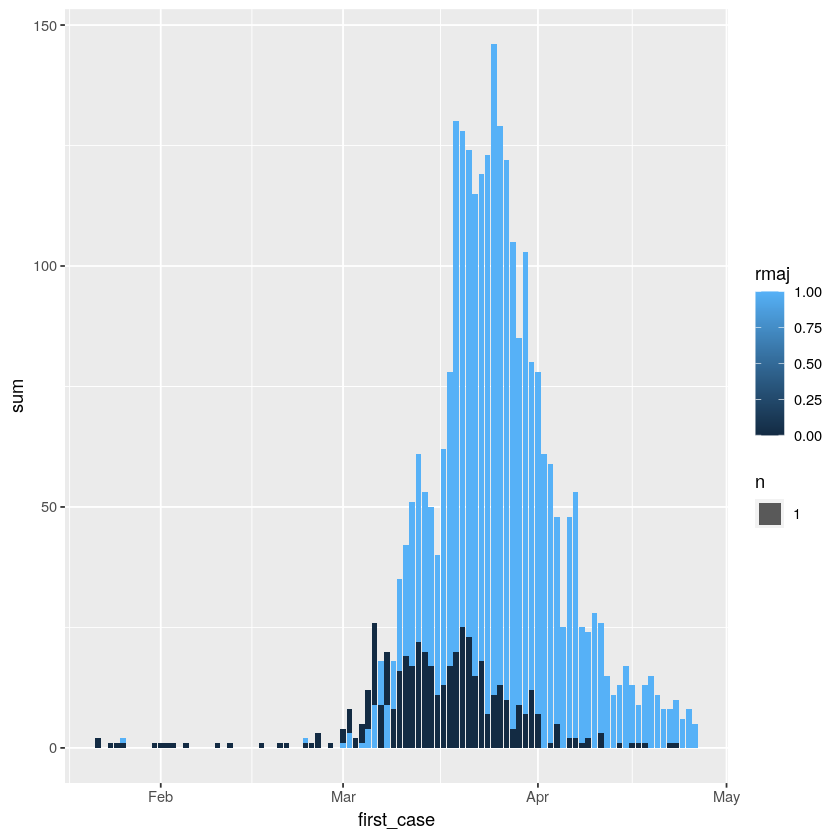

In [70]:
# distribution of first cases
ggplot(data = first, 
       aes(x = first_case, y = sum, fill = rmaj)) + 
  geom_bar(stat = 'sum', position = 'stack')

Most republican counties had not even seen their first case by the time social distancing guidelines were implemented.

Guidelines to restrict travel and avoid gatherings of more than 10 issued march 16: https://www.usatoday.com/story/news/health/2020/03/16/coronavirus-live-updates-us-death-toll-rises-cases-testing/5053816002/

In [81]:
# average date of first case for majority republican
mean.Date(df[df$rmaj == 1, 'first_case'], na.rm = TRUE)

[1] "2020-03-26"

In [82]:
# average date of first case for majority dem
mean.Date(df[df$rmaj == 0, 'first_case'], na.rm = TRUE)

[1] "2020-03-16"

In [246]:
# difference of means test for when first case was by party
t.test(yday(df[df$rmaj == 1, 'first_case']), yday(df[df$rmaj == 0, 'first_case']))


	Welch Two Sample t-test

data:  yday(df[df$rmaj == 1, "first_case"]) and yday(df[df$rmaj == 0, "first_case"])
t = 16.534, df = 551.57, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.997107 11.423035
sample estimates:
mean of x mean of y 
 86.76763  76.55756 
